```bash
python -m carps.analysis.gather_data runs_eval --n_processes 1
```
or when concatenating other people's logs:
```bash
make gather-data
```

In [82]:
from carps.analysis.generate_report import load_results
from carps.analysis.gather_data import normalize_logs
import pandas as pd
from pathlib import Path
from carps.analysis.utils import filter_only_final_performance
from carps.analysis.gather_data import filelogs_to_df, get_interpolated_performance_df
from adaptaf.utils import postprocess_benchmarks, RWBM

df_final_fn = "eval_final_perf.parquet"
logs_fn = "logs.parquet"
logs_cfg_fn = "logs_cfg.parquet"
key_performance = "log_regret"

def filter_experiments(logs: pd.DataFrame) -> pd.DataFrame:
    return logs[
        ((logs["optimizer_id"].str.startswith("PPO-AlphaNet")) \
        | (logs["optimizer_id"].str.startswith("Default")) \
        | (logs["optimizer_id"].str.startswith("SAWEI")) \
        | (logs["optimizer_id"].str.startswith("SMAC-AC--")) \
        | (logs["optimizer_id"].str.startswith("PPO-24")) \
        | (logs["optimizer_id"].str.startswith("PPO-fid8")) \
        | (logs["optimizer_id"].str.startswith("SMAC-AC--24")) \
        | (logs["optimizer_id"].str.startswith("SMAC-AC--fid8"))) \

        & (~logs["optimizer_id"].str.contains("Ssmart"))
    ]


In [83]:

import importlib
import adaptaf.utils as au
importlib.reload(au)
from adaptaf.utils import postprocess_benchmarks
import numpy as np

result_dir = Path("../results_alphanet2")

# Load and merge
logs = load_results(result_dir / "logs.parquet")
logs_cfg = pd.read_parquet(result_dir / "logs_cfg.parquet")
assert logs["experiment_id"].nunique() == len(logs_cfg)
logs = normalize_logs(logs)

logs.loc[logs["benchmark_id"] == "BNNBO", "benchmark_id"] = RWBM  # fix legacy naming
logs = postprocess_benchmarks(logs, logs_cfg)

def fix_benchmark_id(row: pd.Series) -> str:
    if row["task_id"].startswith("bbob/2"):
        return "BBOB-2d"
    if row["task_id"].startswith("bbob/8"):
        return "BBOB-8d"
    return row["benchmark_id"]
logs["benchmark_id"] = logs.apply(fix_benchmark_id, axis="columns")

def reduce_opt_id(optimizer_id: str) -> str:
    prefixes = [
        "PPO-AlphaNet--dacbo_Cepisode_length_scaled_plus_logregret",
        "PPO-AlphaNet2--dacbo_Cepisode_length_scaled_plus_logregret",
        "PPO-AlphaNet3--dacbo_Cepisode_length_scaled_plus_logregret",
        "PPO-AlphaNet--dacbo_Csymlogregret",
        "PPO-AlphaNet2--dacbo_Csymlogregret",
        "PPO-AlphaNet3--dacbo_Csymlogregret",
        "SMAC-AC--dacbo_Cepisode_length_scaled_plus_logregret",
        "SMAC-AC--dacbo_Csymlogregret",
    ]
    for prefix in prefixes:
        if optimizer_id.startswith(prefix):
            if "fid8" in optimizer_id:
                optimizer_id = f"{prefix}Ifid8"
            elif "bbob2d" in optimizer_id:
                optimizer_id = f"{prefix}Ibbob_2d"
            else:
                print(f"Sth is weird for {optimizer_id}")
            break
    optimizer_id = optimizer_id.replace(
        "dacbo_Cepisode_length_scaled_plus_logregret", "eplen").replace(
            "dacbo_Csymlogregret", "symlogregret"
        )
    return optimizer_id
logs["optimizer_id"] = logs["optimizer_id"].map(reduce_opt_id)


logs.to_parquet(logs_fn)
logs_cfg.to_parquet(logs_cfg_fn)
df_final = filter_only_final_performance(logs)
df_final.to_parquet(df_final_fn, index=False)

[11:12:01] INFO     Loading results from ../results_alphanet2/logs.parquet                  ]8;id=380221;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=132734;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1099\1099]8;;\

[11:12:02] INFO     Preprocessing results                                                   ]8;id=917727;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=636116;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1103\1103]8;;\

           INFO     Columns: Index(['task_id', 'optimizer_id', 'seed', 'level_3',           ]8;id=233572;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=18352;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1104\1104]8;;\
                    'n_trials',                                                                                    
                           'n_function_calls', 'trial_info__config',                                               
                    'trial_info__instance',                                                                        
                           'trial_info__seed', 'trial_info__budget',                                               
                           'trial_info__normalized_budget', 'trial_info__name',                                    
                           'trial_info__checkpoint', 'trial_info__cutoff',                                         
                    'trial_value__cost',                                                                           
                           'trial_value__time', 'trial_value__virtual_time',                                       
                    'trial_value__status',                                                                         
                           'trial_value__starttime', 'trial_value__endtime',                                       
                    'benchmark_id',                                                                                
                           'task.optimization_resources.n_trials', 'trial_value__cost_raw',                        
                           'trial_value__cost_inc', 'task_type', 'time', 'experiment_id'],                         
                          dtype='object')                                                                          

           INFO     ...normalizing                                                          ]8;id=920109;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=771841;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1110\1110]8;;\

           INFO     Start normalization...                                                       ]8;id=149797;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=735567;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#611\611]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=840709;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=970677;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#612\612]8;;\

           INFO     Normalize cost...                                                            ]8;id=523709;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=468560;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#614\614]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=42135;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=839998;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#630\630]8;;\

[11:12:05] INFO     Normalize time...                                                            ]8;id=597683;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=925416;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#650\650]8;;\

[11:12:07] INFO     Done.                                                                        ]8;id=614061;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=729918;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#653\653]8;;\

[11:12:11] INFO     Start normalization...                                                       ]8;id=826686;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=1111;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#611\611]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=887890;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=218542;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#612\612]8;;\

           INFO     Normalize cost...                                                            ]8;id=595178;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=288133;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#614\614]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=789044;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=980660;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#630\630]8;;\

[11:12:14] INFO     Normalize time...                                                            ]8;id=905042;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=176003;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#650\650]8;;\

[11:12:16] INFO     Done.                                                                        ]8;id=941054;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=738929;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#653\653]8;;\

/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/adaptaf/adaptaf/utils.py:536: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  


Processing BBOB...


/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/adaptaf/adaptaf/utils.py:422: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  


Processing YAHPO...


100%|██████████| 20/20 [00:00<00:00, 20.42it/s]
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/adaptaf/adaptaf/utils.py:308: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("task_id").apply(calc_fmin).reset_index(drop=True)


Processing nasengb...


100%|██████████| 8/8 [00:00<00:00, 39.14it/s]
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/adaptaf/adaptaf/utils.py:401: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data["log_regret"] = calc_log_regret(data["trial_value__cost_inc"], data["f_min"])
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/adaptaf/adaptaf/utils.py:537: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  def sort_df_by_mean(data: pd.

# Log Regret over Time Single Task

[09:26:36] INFO     Too many optimizers: 18 > 16. Reusing markers.                                      ]8;id=266362;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=256791;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

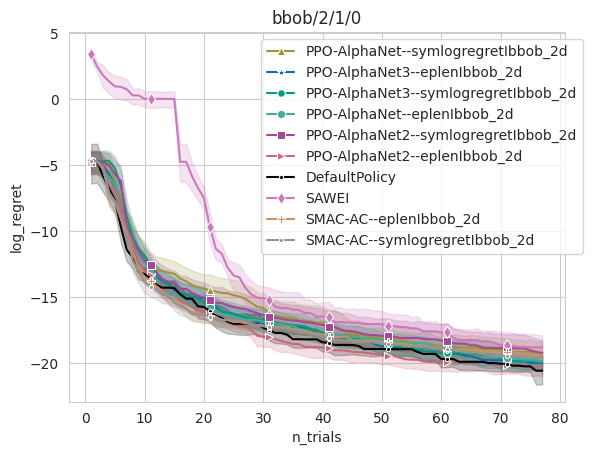

In [5]:

import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn, get_color_palette, get_marker_palette
import pandas as pd

setup_seaborn()
%matplotlib inline

logs = pd.read_parquet(logs_fn)
logs = filter_experiments(logs)
palette = get_color_palette(logs)
palette["DefaultPolicy"] = "black"
marker_palette = get_marker_palette(logs)
for task_id, group in logs.groupby("task_id"):
    if task_id.startswith("bbob/4"):
        continue
    # if task_id != "bbob/8/8/0":
    #     continue
    # if not task_id.startswith("bbob"):
    #     continue
    ax = sns.lineplot(
        data=group, x="n_trials", y=key_performance, hue="optimizer_id", palette=palette, style="optimizer_id", dashes=False, markers=marker_palette, markevery=10)
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_title(task_id)
    plt.show()
    break



# 2d fid8: Final Log Regret Boxplot & Log Regret over Time

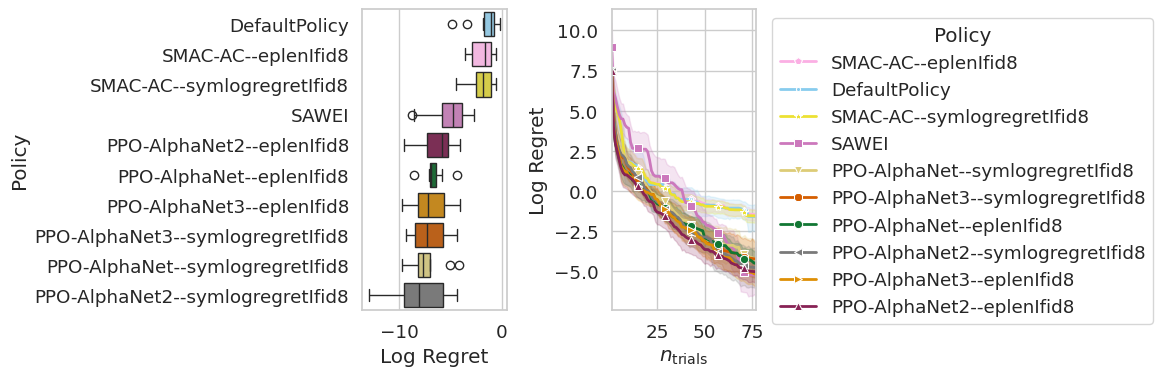

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from adaptaf.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(logs_fn)
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"] == "bbob/2/8/0") \
    & (~logs["optimizer_id"].str.contains("bbob_2d"))
]
logs = sort_df_by_mean(logs, key_performance=key_performance)
df_final = filter_only_final_performance(logs)
df_final = sort_df_by_mean(df_final, key_performance=key_performance)
hue_order = logs["optimizer_id"].unique()
markers = get_marker_palette(logs)

fig = plt.figure(figsize=(12,4))
axes = fig.subplots(ncols=2, sharex=False, sharey=False)
ax = axes[1]
ax = sns.lineplot(data=logs, x="n_trials", y=key_performance, hue="optimizer_id", style="optimizer_id",
             palette=palette, dashes=False, markers=markers, markevery=14, ax=ax, hue_order=hue_order,
             linewidth=2
             )
ax.legend(title="Policy", bbox_to_anchor=(1.05, 1))
ax.set_xlim(logs["n_trials"].min(), logs["n_trials"].max())
ax.set_xlabel("$n_\\mathrm{trials}$")
ax.set_ylabel("Log Regret")

ax = axes[0]
ax = sns.boxplot(data=df_final, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
ax.set_ylabel("Policy")
ax.set_xlabel("Log Regret")
fig.tight_layout()
savefig(fig=fig, filename="figures/results/fid8_2d")
plt.show()


# Fid8: 2d and 8d boxplot

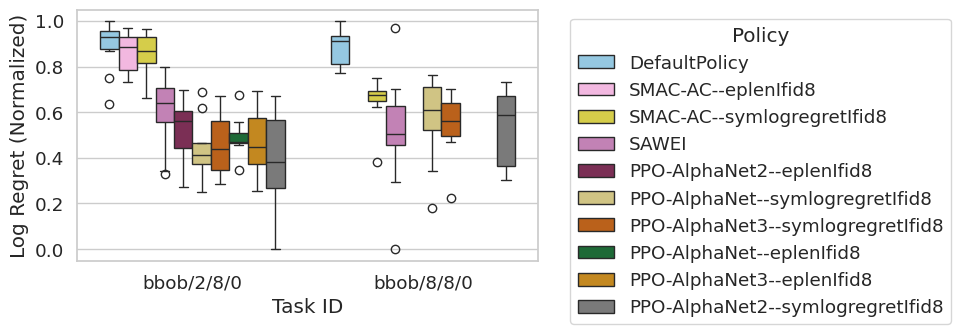

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from adaptaf.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

key_performance = "log_regret"
logs = pd.read_parquet(logs_fn)
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].isin(["bbob/2/8/0","bbob/8/8/0"])) \
    & (~logs["optimizer_id"].str.contains("bbob_2d"))
]
logs = sort_df_by_mean(logs, key_performance=key_performance)
df_final = filter_only_final_performance(logs)

key_performance = "Log Regret (Normalized)"
df_final[key_performance] = df_final.groupby("task_id")["log_regret"].transform(normalize)

df_final = sort_df_by_mean(df_final, key_performance=key_performance)
hue_order = logs["optimizer_id"].unique()
markers = get_marker_palette(logs)

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax = sns.boxplot(
    data=df_final, y=key_performance, hue="optimizer_id", x="task_id", palette=palette, ax=ax)
ax.legend(title="Policy", bbox_to_anchor=(1.05,1))
# ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("Task ID")
fig.tight_layout()
savefig(fig=fig, filename="figures/results/fid8_2d_vs_8d")
plt.show()


# Fid8 Generalization on BBOB 2d

['bbob/2/1/0' 'bbob/2/10/0' 'bbob/2/11/0' 'bbob/2/12/0' 'bbob/2/13/0'
 'bbob/2/14/0' 'bbob/2/15/0' 'bbob/2/16/0' 'bbob/2/17/0' 'bbob/2/18/0'
 'bbob/2/19/0' 'bbob/2/2/0' 'bbob/2/20/0' 'bbob/2/21/0' 'bbob/2/22/0'
 'bbob/2/23/0' 'bbob/2/24/0' 'bbob/2/3/0' 'bbob/2/4/0' 'bbob/2/5/0'
 'bbob/2/6/0' 'bbob/2/7/0' 'bbob/2/8/0' 'bbob/2/9/0']


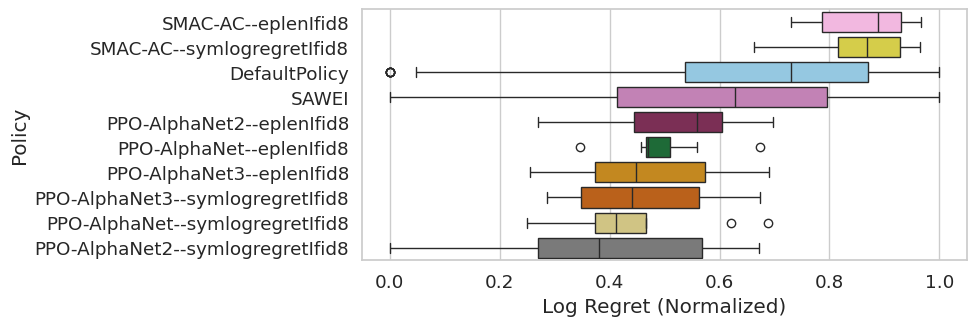

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from adaptaf.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

key_performance = "log_regret"
logs = pd.read_parquet(logs_fn)
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].str.startswith("bbob/2")) \
    & (~logs["optimizer_id"].str.contains("bbob_2d"))
]
print(logs["task_id"].unique())
logs = sort_df_by_mean(logs, key_performance=key_performance)
df_final = filter_only_final_performance(logs)

key_performance_norm = "Log Regret (Normalized)"
df_final[key_performance_norm] = df_final.groupby("task_id")["log_regret"].transform(normalize)

df_final = sort_df_by_mean(df_final, key_performance=key_performance_norm)
hue_order = logs["optimizer_id"].unique()
markers = get_marker_palette(logs)

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax = sns.boxplot(
    data=df_final, x=key_performance_norm, hue="optimizer_id", y="optimizer_id", palette=palette, ax=ax)
# ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("Log Regret (Normalized)")
ax.set_ylabel("Policy")
fig.tight_layout()
savefig(fig=fig, filename="figures/results/fid8_2d_vs_8d")
plt.show()


# BBOB2d on BBOB2d

/tmp/ipykernel_565444/755035292.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  solved_counts = df_plot.groupby("optimizer_id")["solved"].sum()


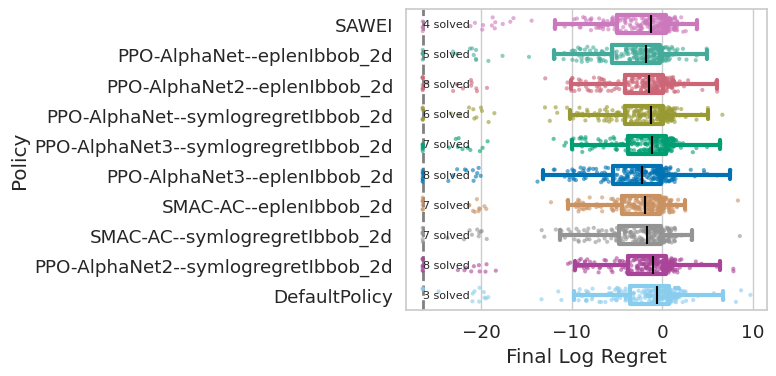

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import adaptaf.utils as au
importlib.reload(au)
from adaptaf.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

key_performance = "log_regret"

logs = pd.read_parquet(logs_fn)
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].str.startswith("bbob/2")) \
    & (~logs["optimizer_id"].str.contains("fid8"))
]
df_final = filter_only_final_performance(logs)

# -----------------------------
# Sort optimizers by performance
# -----------------------------
optimizer_order = (
    df_final
    .groupby("optimizer_id")["regret"]
    .mean()
    .sort_values()
    .index
)

# -----------------------------
# Automatic floor for -inf
# -----------------------------
finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5

# -----------------------------
# Prepare plotting DataFrame
# -----------------------------
df_plot = df_final.copy()
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret_plot"] = df_plot["log_regret"].replace(-np.inf, floor)

df_plot["optimizer_id"] = pd.Categorical(
    df_plot["optimizer_id"],
    categories=optimizer_order,
    ordered=True
)

# -----------------------------
# Main plot: boxplot + jitter + annotations
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4))


sns.stripplot(
    data=df_plot,
    y="optimizer_id",
    hue="optimizer_id",
    palette=palette,
    x="log_regret_plot",
    order=optimizer_order,
    jitter=0.25,
    size=3,
    alpha=0.6,
    ax=ax
)

sns.boxplot(
    data=df_plot,
    y="optimizer_id",
    x="log_regret_plot",
    hue="optimizer_id",
    palette=palette,
    order=optimizer_order,
    width=0.6,
    fliersize=0,
    ax=ax,
    fill=False,
    zorder=9999,
    linewidth=3,
    medianprops={"color": "black", "linewidth": 1.5},
)



# Annotate solved counts
solved_counts = df_plot.groupby("optimizer_id")["solved"].sum()

for y, opt in enumerate(optimizer_order):
    ax.text(
        floor + 0.02,
        y,
        f"{solved_counts[opt]} solved",
        va="center",
        ha="left",
        fontsize=8
    )

ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
ax.set_xlabel("Final Log Regret")
ax.set_ylabel("Policy")
plt.tight_layout()
savefig(fig=fig, filename="bbob2d_on_bbob2d")
plt.show()




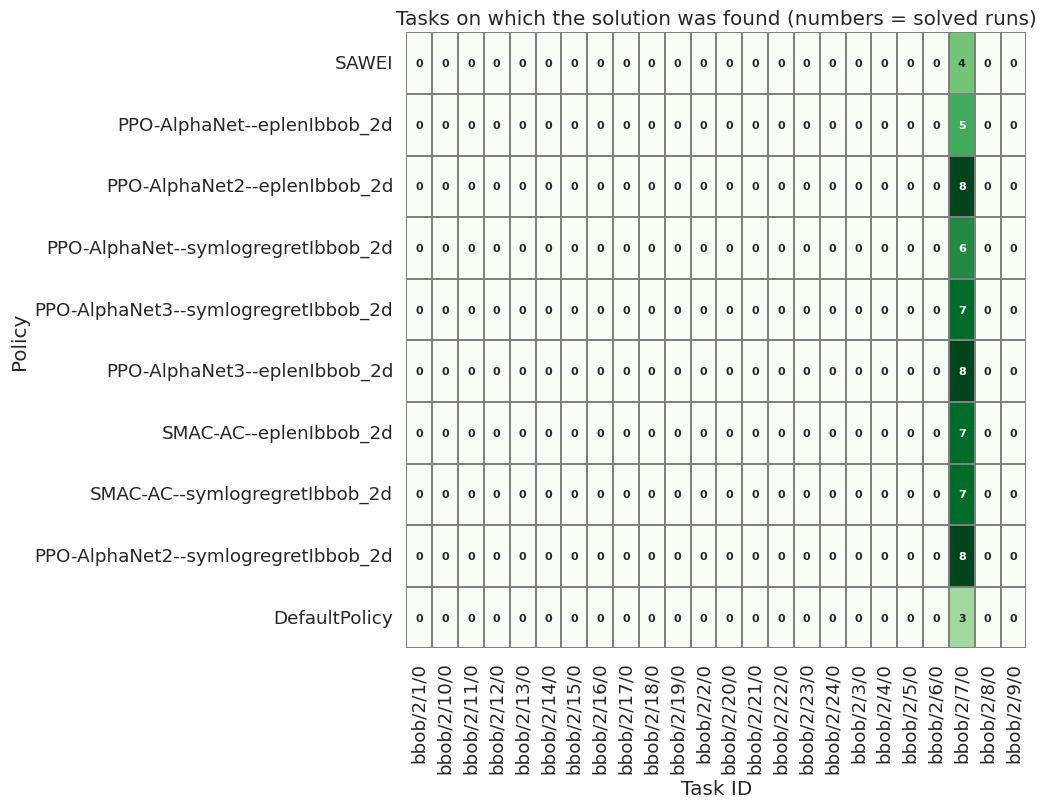

In [118]:
# -----------------------------
# Heatmap with solved counts per cell
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: number of runs solved per task & optimizer
# 1 if log_regret = -inf, 0 otherwise
df_solved = df_final.copy()
df_solved["solved"] = (df_solved["log_regret"] == -np.inf).astype(int)

# Pivot table: tasks x optimizers, sum over multiple runs
task_counts = df_solved.pivot_table(
    index="task_id",
    columns="optimizer_id",
    values="solved",
    aggfunc="sum",
    fill_value=0
).reindex(columns=optimizer_order)

# Binary mask for heatmap coloring: 1 = solved at least once
task_binary = (task_counts > 0).astype(int)

fig, ax = plt.subplots(figsize=(8, 8))

# Base heatmap: solved vs not solved
sns.heatmap(
    task_counts.T,
    cbar=False,
    linewidths=0.3,
    linecolor="gray",
    cmap="Greens",
    ax=ax,
    annot=task_counts.T,      # overlay the **number of solved runs**
    fmt="d",
    annot_kws={"fontsize": 8, "fontweight": "bold"}
)

ax.set_ylabel("Policy")
ax.set_xlabel("Task ID")
ax.set_title("Tasks on which the solution was found (numbers = solved runs)")

# plt.tight_layout()
savefig(fig=fig, filename="sol_found_bbob2d")
plt.show()


# Final Log Regret Agg Benchmark

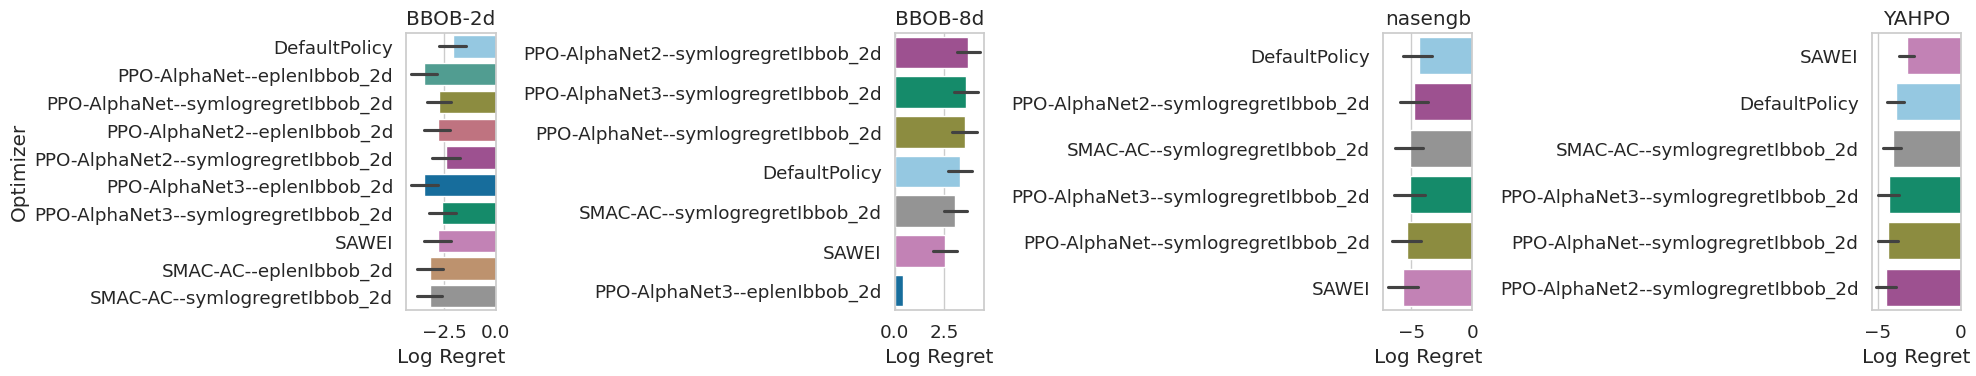

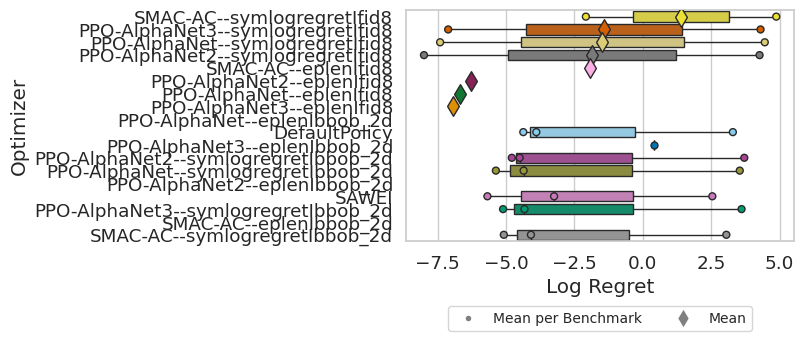

In [123]:
from adaptaf.utils import sort_df_by_mean
from carps.analysis.utils import filter_only_final_performance, savefig
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

df_final = pd.read_parquet(df_final_fn)

finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret"] = df_plot["log_regret"].replace(-np.inf, floor)

methods_overview_plot = df_final["optimizer_id"].unique()

n_benchmarks = df_final["benchmark_id"].nunique()
benchmark_ids = df_final["benchmark_id"].unique()
color_palette = get_color_palette(df_final)

fig = plt.figure(figsize=(5 * n_benchmarks, 4))
axes = fig.subplots(nrows=1, ncols=n_benchmarks, sharex=False, sharey=False)

for i, benchmark_id in enumerate(benchmark_ids):
    ax = axes[i]
    df_bench = df_final[
        (df_final["benchmark_id"] == benchmark_id) & \
        (df_final["optimizer_id"].str.contains("bbob_2d") | \
         df_final["optimizer_id"].str.contains("Default") | \
         df_final["optimizer_id"].str.contains("SAWEI")
         )
    ]
    df_bench = sort_df_by_mean(df_bench, key_performance=key_performance)
    ax = sns.barplot(
        data=df_bench, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=color_palette, ax=ax)

    yticklabels = ax.get_yticklabels()
    ax.set_title(benchmark_id)
    ax.set_xlabel("Log Regret")
    ylabel = "Optimizer" if i == 0 else None
    ax.set_ylabel(ylabel)
fig.tight_layout()
savefig(fig, "figures/results/perf_per_benchmark")
plt.show()


df_reduced = df_final.groupby(["optimizer_id", "benchmark_id"])[key_performance].mean().reset_index()
df_reduced = sort_df_by_mean(data=df_reduced, key_performance=key_performance)
df_reduced_reduced = df_reduced.groupby(["optimizer_id"])[key_performance].mean().reset_index()
df_reduced_reduced = sort_df_by_mean(data=df_reduced_reduced, key_performance=key_performance)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax, palette=color_palette)
ax = sns.stripplot(data=df_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax, palette=color_palette, linewidth=1, jitter=False)
ax = sns.stripplot(
    data=df_reduced_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax,
    palette=color_palette, linewidth=1, size=10, marker="d", jitter=False)
yticklabels = ax.get_yticklabels()

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Mean per Benchmark",
           markerfacecolor="grey", markersize=5),  # small circle
    Line2D([0], [0], marker="d", color="w", label="Mean",
           markerfacecolor="grey", markersize=10)   # larger diamond
]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.25), ncols=2, fontsize=10, loc="upper center")
ax.set_xlabel("Log Regret")
ax.set_ylabel("Optimizer")
savefig(fig, "figures/results/perf_on_all")
plt.show()

